# Notes

In [55]:
# install packages via terminal:
# conda install pydotplus
# conda install graphviz

# Import Libraries and Dataset

In [83]:
# import libraries
import pandas as pd
import numpy as np
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
import pydotplus

In [57]:
# import data
data = pd.read_csv("WholeDataset.csv")
data.head(11)

,age,gender,No_jumpers_per_year,spent_in_the_last_week,spent,salaRy,Decision
0,23,Female,10,92,327,2.305767e+05,NaN
1,27,Female,10,174,538,1.295333e+05,NaN
2,23,Female,10,230,884,2.134858e+05,NaN
3,32,Female,10,188,576,1.565767e+05,NaN
4,33,Female,10,135,384,7.805767e+05,NaN
5,16,Female,10,206,816,5.565767e+05,NaN
6,71,Female,10,247,821,2.230896e+05,NaN
7,25,Female,10,81,129,1.118075e+05,NaN
8,19,Female,10,250,949,1.594243e+06,NaN
9,64,Female,10,63,158,3.285767e+05,NaN


# Explore and clean Data

### General Descriptives

In [58]:
data.shape

(701, 7)

In [59]:
data.describe()

,age,No_jumpers_per_year,spent_in_the_last_week,spent,salaRy,Decision
count,701.000000,701.000000,701.000000,701.000000,7.010000e+02,502.000000
mean,47.733238,4.748930,126.111270,419.134094,2.393763e+05,0.380478
std,22.017432,3.132733,72.473831,279.403951,2.604241e+05,0.485989
min,16.000000,0.000000,4.000000,7.000000,1.560000e+04,0.000000
25%,25.000000,2.000000,63.000000,161.000000,7.741545e+04,0.000000
50%,49.000000,5.000000,121.000000,384.000000,1.634101e+05,0.000000
75%,66.000000,7.000000,188.000000,658.000000,2.922319e+05,1.000000
max,90.000000,10.000000,250.000000,992.000000,1.820577e+06,1.000000


### Gender Studies

In [60]:
data.groupby("gender").No_jumpers_per_year.mean()

gender
Female    7.346154
M         6.914286
Male      8.056604
female    3.721805
m         4.000000
male      4.078947
Name: No_jumpers_per_year, dtype: float64

In [61]:
genders = set(data["gender"])
genders

{'Female', 'M', 'Male', 'female', 'm', 'male'}

In [62]:
# a better way
data.gender.unique()

array(['Female', 'Male', 'male', 'M', 'female', 'm'], dtype=object)

### Data Cleansing

In [63]:
data.columns

Index(['age', 'gender', 'No_jumpers_per_year', 'spent_in_the_last_week',
       'spent', 'salaRy', 'Decision'],
      dtype='object')

In [64]:
# change column names using a dictionary
data.rename(columns = {"No_jumpers_per_year":"jumpers_year","spent_in_the_last_week":"spent_week","spent":"spent_month","salaRy":"salary","Decision":"decision"}, inplace = True)
data.columns

Index(['age', 'gender', 'jumpers_year', 'spent_week', 'spent_month', 'salary',
       'decision'],
      dtype='object')

In [65]:
# standardize gender names - using a list for male
data["gender"] = data["gender"].replace("female","Female")
data["gender"] = data["gender"].replace(["male","M","m"],"Male")
data.gender.unique()

array(['Female', 'Male'], dtype=object)

In [66]:
# change decision datatype to categorical to avoid algorithm using regression rather than regular decision tree
data["decision"] = data["decision"].replace(1,"yes")
data["decision"] = data["decision"].replace(0,"no")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 7 columns):
age             701 non-null int64
gender          701 non-null object
jumpers_year    701 non-null int64
spent_week      701 non-null int64
spent_month     701 non-null int64
salary          701 non-null float64
decision        502 non-null object
dtypes: float64(1), int64(4), object(2)
memory usage: 38.4+ KB


# Running the Model

### Divide Dataset

In [67]:
# drop all datapoints with no data on decision
NoPredict = data.dropna()
NoPredict.head()

,age,gender,jumpers_year,spent_week,spent_month,salary,decision
33,66,Female,10,126,409,207338.6489,yes
34,50,Female,10,61,214,226576.7442,yes
35,81,Female,10,167,632,193148.1728,yes
36,18,Female,10,150,540,138158.1395,yes
37,68,Female,10,86,332,267961.3596,yes


In [68]:
# define dataset with datapoints to be predicted
Predict = data[pd.isnull(data["decision"])]
Predict.head()

,age,gender,jumpers_year,spent_week,spent_month,salary,decision
0,23,Female,10,92,327,230576.7442,NaN
1,27,Female,10,174,538,129533.2659,NaN
2,23,Female,10,230,884,213485.8351,NaN
3,32,Female,10,188,576,156576.7442,NaN
4,33,Female,10,135,384,780576.7442,NaN


### Some Graphs

<function matplotlib.pyplot.show>

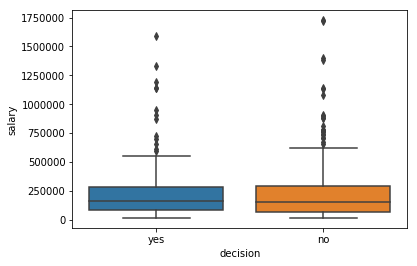

In [69]:
sns.boxplot(y="salary", x="decision", data = NoPredict)
plt.show

<function matplotlib.pyplot.show>

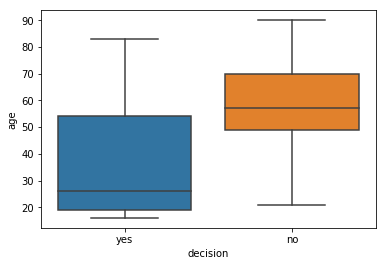

In [70]:
sns.boxplot(y="age", x="decision", data = NoPredict)
plt.show

<function matplotlib.pyplot.show>

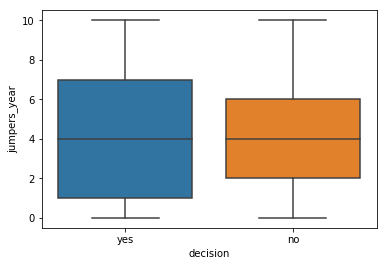

In [71]:
sns.boxplot(y="jumpers_year", x="decision", data = NoPredict)
plt.show

### Build model

In [72]:
# define independent variables
feature_cols = ['age', 'gender', 'jumpers_year', 'spent_week', 'spent_month', 'salary']

# define variable
x = NoPredict[feature_cols]
y = NoPredict.decision

In [73]:
# split dataset into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 123)

In [74]:
# convert categorical variables into dummies
x_train = pd.get_dummies(x_train)
x_test = pd.get_dummies(x_test)

In [75]:
# define and fit decision tree model
clf = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 5)
clf.fit(x_train, y_train)
y_predict = clf.predict(x_test)

In [88]:
# assess the accuracy of the model
print("Accuracy: ", metrics.accuracy_score(y_test,y_predict))

Accuracy:  0.9047619047619048


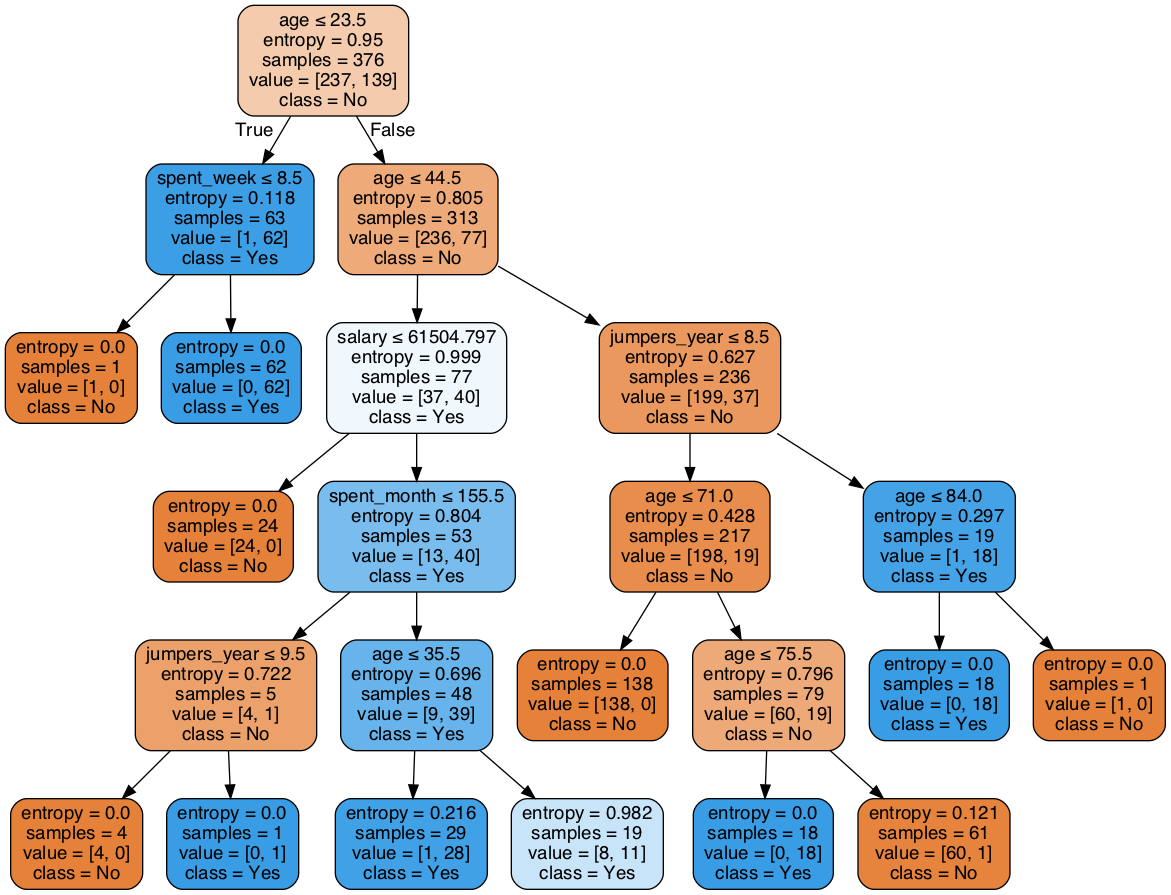

In [86]:
# print the underlying decision tree
dot_data = StringIO()
export_graphviz(clf, out_file = dot_data,
                filled = True, rounded = True, 
                special_characters = True,
                feature_names = x_train.columns,
                class_names = ["No", "Yes"])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())